## <i> mrjob</i>

<i>Info: </i> combiner is used on the same machine as a mapper. It is usefull as less data should be passed to reducer (which is another machine). Additionally, combiner sees only a part of data, so the same operation should be performed on combiner and reducer.

#### Libraries

In [1]:
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
import pandas as pd
import matplotlib.pyplot as plt

#### Help functions/variable

In [2]:
WORD_RE = re.compile(r"[\w']+")

#### Show all words in the text and count its number using MapReduce

In [ ]:
class MRWC(MRJob):
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   combiner=self.combiner_count_words,
                   reducer=self.reduce_count_words)
            
        ]
    
    def mapper_get_words(self, _, line):
        for word in WORD_RE.findall(line):
            yield (word.lower(), 1)
    
    def combiner_count_words(self, words, count):
        yield (words, sum(count))
    
    def reduce_count_words(self, words, count):
        yield (words, sum(count))


if __name__ == "__main__":
    MRWC.run()

#### Find most used word and its count using MapReduce

In [ ]:
class MRWC(MRJob):
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_words,
                   combiner=self.combiner_count_words,
                   reducer=self.reduce_count_words),
            MRStep(reducer=self.reduce_find_max_word)
        ]
    
    def mapper_get_words(self, _, line):
        for word in WORD_RE.findall(line):
            yield (word.lower(), 1)
    
    def combiner_count_words(self, words, count):
        yield (words, sum(count))
    
    def reduce_count_words(self, words, count):
        yield None, (sum(count), words)
    
    def reduce_find_max_word(self, _, word_count_pairs):
        yield max(word_count_pairs)


if __name__ == "__main__":
    MRWC.run()

#### Working with GCP

In [ ]:
# copy files from bucket
gsutil cp gs://bucket_name/simple.txt .
    
# redirect output and errors to separate files but also show in console
python2 mr_word_count.py -r dataproc text_template.txt 1> >(tee hadoop.simple.out) 2> >(tee hadoop.simple.log)

# copy outputs 
gsutil cp ./hadoop.simple.log  gs://bucket_name/

#### Plot Zipf’s law graph (if one plots word frequency against frequency rank, the resulting line is linear (almost) on a log-log scale)

In [3]:
# get data that was obtained using GCP
df = pd.read_csv('./help/hadoop.simple.out', delimiter = "\t", header=None)

In [4]:
# sort values
df = df.sort_values(by=1, ascending=False)

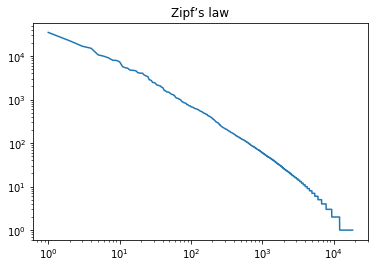

In [5]:
# plot
plt.plot(range(1, len(df) + 1), df[1])
plt.title('Zipf’s law')

_ = plt.loglog()

#### Calculater the number of samples for each label, its mean and variance

Variance can be calculated using the following formula:

$$\sigma^2 = \frac{\sum_{} X^2}{N} - \mu^2 $$

You take the sum of the squares of the terms in the distribution, and divide by the number of terms in the distribution (N). From this, you subtract the square of the mean (μ2).

In [ ]:
class MRWC(MRJob):
    
    def steps(self):
        return [
            MRStep(mapper=self.mapper_in,
                   reducer=self.reduce_sum_values),
            MRStep(reducer=self.reduce_calc_mean_var)
        ]
    
    def mapper_in(self, _, line):
        label = line.split()[0]
        value = float(line.split()[1])
        
        yield label, [1, value, value**2]
    
    def reduce_sum_values(self, label, values):
        sum_of_el = 0
        sum_of_elem = 0
        sum_of_elem_sq = 0
        
        for elem in values:
            sum_of_el += elem[0]
            sum_of_elem += elem[1]
            sum_of_elem_sq += elem[2]
            
        yield label, [sum_of_el, sum_of_elem, sum_of_elem_sq]
    
    def reduce_calc_mean_var(self, label, values):
        # value[0] - num_of_samples
        # value[1] - sum of elem
        # value[2] - sum of elem^2
        
        values_list = list(values)[0]
        
        num_of_samples = values_list[0]
        mean = values_list[1] / num_of_samples
        var = (values_list[2] / num_of_samples) - mean**2
        
        yield label, [num_of_samples, mean, var]


if __name__ == "__main__":
    MRWC.run()